In [1]:
%run ./data_utils.ipynb
%run ./model.ipynb

In [2]:
dataUtils = DataUtils(min_word_frequency = 2)
sentences_train, sentence_test, classes_train, classes_test = dataUtils.get_glove_indexed_sentence_class(0.01)

loading data ...
---done!---
creating vocabulary ...
---done!---
numericalizing sentences ...
---done!---!
sentences: 7109 sentences: 7109 Vocab: 8458
loading glove ...
---done!---


In [3]:
class Dataset_(torch.utils.data.Dataset):
    def __init__(self, sentences, classes):
        self.X, self.y = sentences, classes
    def __len__(self):
        return len(self.X)
    def __getitem__(self, index):
        classs = self.y[index]
        sentence = self.X[index]
        
        return (torch.tensor(sentence[0]), torch.tensor(sentence[1])), classs

In [24]:
embed_size = 300
hidden_size = 150
vocab_size = len(dataUtils.vocabulary)
class_size = 10
num_layers = 2

learning_rate = 6e-4
num_epochs = 30
load_model = False
save_model = True
batch_size = 16
valid_batch_size = 200

In [25]:
train_data = Dataset_(sentences_train, classes_train)
validation_data = Dataset_(sentence_test, classes_test)

train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(dataset=validation_data, batch_size=valid_batch_size, shuffle=True)

In [6]:
torch.backends.cudnn.benchmark = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
%run ./data_utils.ipynb
%run ./model.ipynb
model = RelationNet_glove_indexed(embed_size, hidden_size, vocab_size, class_size, num_layers).to(device)
criterion = nn.NLLLoss(ignore_index = dataUtils.rev_vocabulary["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

if load_model:
    model = torch.load("my_checkpoint_glove_indexed.pth.tar")

In [8]:
train_losses = []
train_accs = []
validation_losses = []
validation_accs = []

In [9]:
model.train()
dataloader_iterator = iter(validation_loader)
validation_sentences, validation_classes = next(dataloader_iterator)
validation_sentences = (validation_sentences[0].to(device), validation_sentences[1].to(device))
validation_classes = validation_classes.to(device)

for epoch in range(num_epochs):
    batches_losses = []
    batches_accs = []
    print('-'*8+"epoch:"+str(epoch)+'-'*8)
    
    for idx, (sentence, c) in enumerate(train_loader):
        sentence = (sentence[0].to(device), sentence[1].to(device))
        c = c.to(device)

        outputs = model(sentence)
        loss = criterion(outputs, c)
        
        batches_losses.append(loss.item())
        batches_accs.append(1-torch.count_nonzero(torch.argmax(outputs, dim = 1)-c)/batch_size)
        
        optimizer.zero_grad()
        loss.backward(loss)
        optimizer.step()
        
        print(str(round(idx/440*100, 2))+'%', end="\r")
        
    train_losses.append(np.array(batches_losses).mean()) 
    train_accs.append(np.array(batches_accs).mean())
    
    validation_outputs = model(validation_sentences)
    validation_loss = criterion(validation_outputs, validation_classes)
    validation_losses.append(validation_loss.item())
    validation_accs.append(1-float(torch.count_nonzero(torch.argmax(validation_outputs, dim = 1)-validation_classes)/valid_batch_size))
    
    if save_model and validation_accs[-1] >= max(validation_accs):
        print('saving model ...')
        torch.save(model, "my_checkpoint_glove_indexed.pth.tar")
    
    print("epoch train loss:\t"+ str(round(train_losses[-1],3)) + "\tepoch validation loss:\t" + str(round(validation_losses[-1],3)))
    print("epoch train acc:\t" + str(round(train_accs[-1],3)) + "\tepoch validation acc:\t" + str(round(validation_accs[-1],3)))
    

--------epoch:0--------
saving model ...
epoch train loss:	1.662	epoch validation loss:	1.55
epoch train acc:	0.348	epoch validation acc:	0.4
--------epoch:1--------
saving model ...
epoch train loss:	1.211	epoch validation loss:	1.222
epoch train acc:	0.493	epoch validation acc:	0.6
--------epoch:2--------
epoch train loss:	1.05	epoch validation loss:	1.111
epoch train acc:	0.547	epoch validation acc:	0.55
--------epoch:3--------
saving model ...
epoch train loss:	0.933	epoch validation loss:	0.963
epoch train acc:	0.579	epoch validation acc:	0.65
--------epoch:4--------
saving model ...
epoch train loss:	0.84	epoch validation loss:	1.023
epoch train acc:	0.611	epoch validation acc:	0.675
--------epoch:5--------
epoch train loss:	0.781	epoch validation loss:	1.001
epoch train acc:	0.628	epoch validation acc:	0.6
--------epoch:6--------
epoch train loss:	0.714	epoch validation loss:	1.054
epoch train acc:	0.651	epoch validation acc:	0.625
--------epoch:7--------
epoch train loss:	0.637

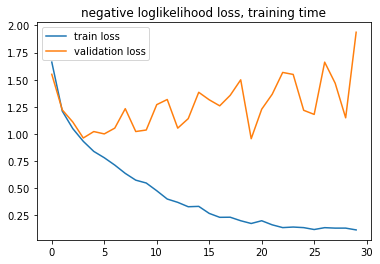

In [10]:
plt.plot(train_losses, label = "train loss")
plt.plot(validation_losses, label = "validation loss")
plt.title("negative loglikelihood loss, training time")
plt.legend()

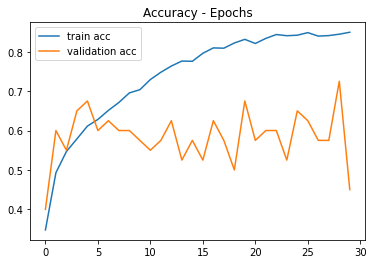

In [11]:
plt.plot(train_accs, label = "train acc")
plt.plot(validation_accs, label = "validation acc")
plt.title("Accuracy - Epochs")
plt.legend()

In [30]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

model = torch.load("my_checkpoint_glove_indexed.pth.tar")

dataloader_iterator = iter(validation_loader)
validation_sentences, validation_classes = next(dataloader_iterator)
validation_sentences = (validation_sentences[0].to(device), validation_sentences[1].to(device))
validation_classes = validation_classes.to(device)
validation_outputs = model(validation_sentences)

In [31]:
accuracy_score(validation_classes, torch.argmax(validation_outputs, dim = 1))

0.6111111111111112

In [42]:
cm = confusion_matrix(validation_classes, torch.argmax(validation_outputs, dim = 1))

In [38]:
a = precision_recall_fscore_support(validation_classes, np.array(torch.argmax(validation_outputs, dim = 1)))

/Users/ali/miniforge_x86_64/envs/pytorch_x86/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
